### Tensorflow Regression Zn drop

In [85]:
import pathlib
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

###### Import the dataset

In [90]:
# dataset_path = r'C:\Users\v.t.flores\Documents\ZnNi_project_2015_2020_dataset.xlsx'
#Loading the new dataset that has the new value for negative infinity values

#dataset_path = r'C:\Users\v.t.flores\Documents\ZnNi_project_2015_2020_dataset3.xlsx'

dataset_path = r'C:\Users\v.t.flores\Documents\ZnNi_project_2015_2020_dataset3.xlsx'

raw_dataset = pd.read_excel(dataset_path)
dataset = raw_dataset.set_index('DATETIME')

for col in dataset.columns:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')
dataset.interpolate(method='linear', limit_direction = 'forward', inplace=True)

###### Clean the data

In [4]:
dataset = dataset.dropna()

In [5]:
dataset.columns

Index(['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu', '104_Fe', '104_Fe2',
       '104_Ft', '104_Mg', '104_Mn', '104_NTU', '104_Ni', '104_ORP', '104_Pb',
       '104_Si', '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'H2S_tk01', 'H2S_tk02', '106_Ni', '106_Zn', 'tk05_Al', 'tk05_Ca',
       'tk05_Co', 'tk05_Cr', 'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn',
       'tk05_Ni', 'tk05_Pb', 'tk05_Si', 'tk05_Zn', 'DeZn_TK05_T', 'tk03_Zn',
       'Zn_Drop', 'ZnNi_Ratio'],
      dtype='object')

In [91]:
# dataset_path = r'C:\Users\v.t.flores\Documents\ZnNi_project_2015_2020_dataset.xlsx'
#Loading the new dataset that has the new value for negative infinity values
columns_include = ['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu',
                   '104_Fe', '104_Fe2','104_Ft', '104_Mg', '104_Mn', 
                   '104_NTU', '104_Ni', '104_ORP', '104_Pb','104_Si', 
                   '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T','DeZn_TK05_T', 
                   'H2S_tk01', 'H2S_tk02', 'Zn_Drop','tk05_Al', 'tk05_Ca',
                   'tk05_Co', 'tk05_Cr', 'tk05_Cu', 'tk05_Fe','tk05_Mg',
                   'tk05_Mn', 'tk05_Ni', 'tk05_Pb', 'tk05_Si', 'tk05_Zn']

dataset_path_dataset2 = r'C:\Users\v.t.flores\Documents\ZnNi_project_2015_2020_dataset3.xlsx'
raw_dataset2 = pd.read_excel(dataset_path_dataset2)
dataset2 = raw_dataset2.set_index('DATETIME')

for col in dataset2.columns:
    dataset2[col] = pd.to_numeric(dataset2[col], errors='coerce')
dataset2.interpolate(method='linear', limit_direction = 'forward', inplace=True)

dataset2 = dataset2[columns_include]

In [92]:
len(dataset2.columns)

35

In [93]:
dataset2 = dataset2.drop(dataset2.loc['2020-08-01 00:00:00':'2020-09-29 00:00:00'].index) # remove the august and september2020 data to prior to training

###### Split data into train and test

In [59]:
features_list = ['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu', 
            '104_Fe', '104_Fe2','104_Ft', '104_Mg', '104_Mn', 
            '104_NTU', '104_Ni','104_ORP','104_Pb','104_Si', 
            '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T','DeZn_TK05_T',
            'H2S_tk01', 'H2S_tk02', 'tk05_Al','tk05_Ca', 'tk05_Co', 
            'tk05_Cr', 'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn',
            'tk05_Ni', 'tk05_Pb', 'tk05_Si', 'tk05_Zn']


In [94]:
train_dataset2 = dataset2.sample(frac=0.8, random_state=0)
test_dataset2 = dataset2.drop(train_dataset2.index)


###### Inspect the data

In [95]:
# Also look at the overall statistics:

train_stats = train_dataset2.describe()
train_stats.pop('Zn_Drop')
train_stats = train_stats.transpose()

##### Split features from labels

In [96]:
#Separate the target value, or "label", from the features. 
#This label is the value that you will train the model to predict.

train_labels = train_dataset2.pop('Zn_Drop')
test_labels = test_dataset2.pop('Zn_Drop')

In [97]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset2)
normed_test_data = norm(test_dataset2)
#normed_train_labels = norm(train_labels)

In [98]:
print(normed_train_data.describe().columns)
print(len(normed_train_data.describe().columns))

Index(['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu', '104_Fe', '104_Fe2',
       '104_Ft', '104_Mg', '104_Mn', '104_NTU', '104_Ni', '104_ORP', '104_Pb',
       '104_Si', '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'DeZn_TK05_T', 'H2S_tk01', 'H2S_tk02', 'tk05_Al', 'tk05_Ca', 'tk05_Co',
       'tk05_Cr', 'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn', 'tk05_Ni',
       'tk05_Pb', 'tk05_Si', 'tk05_Zn'],
      dtype='object')
34


In [99]:
len(features_list)

34

#### The model

In [15]:
# add regularization parameters to the model
def build_model():
    model = keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu, 
                 kernel_regularizer=regularizers.l2(0.0001), 
                 input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5),
    layers.Dense(512, activation=tf.nn.relu,
                kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),    
    layers.Dense(512, activation=tf.nn.relu,
                kernel_regularizer=regularizers.l2(0.0001)),        
    layers.Dropout(0.5),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [16]:

 
#    tf.keras.layers.Flatten(input_shape=(28, 28))



In [17]:
model_Zdrop = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
# Use the .summary method to print a simple description of the model

model_Zdrop.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               19968     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

In [19]:
example_batch = normed_train_data[:10]
example_result = model_Zdrop.predict(example_batch)
example_result

array([[-0.28127542],
       [-0.20396838],
       [-0.22847083],
       [-0.21636942],
       [-0.33971468],
       [-0.16245206],
       [-0.25231653],
       [ 0.00398201],
       [-0.26224113],
       [-0.01852874]], dtype=float32)

In [18]:
# the array should display 10 values representing the Zn Drop predictions

##### Train the model

In [20]:
# Display training progress by printing a single dot for each completed epoch

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')




In [20]:
#hist = pd.DataFrame(history.history)
#hist['epoch'] = history.epoch
#hist.tail()

In [100]:
import matplotlib.pyplot as plt

In [80]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Zn_drop]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
            label= 'Val Error')
    plt.legend()
    plt.ylim([-100, 100])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Zn_drop]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
            label= 'Val Error')
    plt.legend()
    plt.ylim([0, 1])
    



In [23]:
model_Zdrop = build_model()

In [101]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [27]:
# The patience parameter is the amount of epochs to check for improvement
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, mode='auto', verbose=0)



history = model_Zdrop.fit(train_dataset, train_labels, epochs=EPOCHS,
                   validation_split = 0.2, verbose=1, callbacks=[early_stop])

plot_history(history)



In [88]:
train_labels.min()

-11528.97196261682

##### testing to display the accuracy and loss while training

In [103]:
# testing

model = keras.Sequential([layers.Dense(512, activation=tf.nn.relu, 
                                       kernel_regularizer=regularizers.l2(0.0001), 
                                       input_shape=[len(train_dataset2.keys())]),
                          layers.Dropout(0.5),
                          layers.Dense(512, activation=tf.nn.relu,
                                       kernel_regularizer=regularizers.l2(0.0001)),
                          layers.Dropout(0.5),
                          layers.Dense(512, activation=tf.nn.relu,
                                       kernel_regularizer=regularizers.l2(0.0001)),        
                          layers.Dropout(0.5),
                          layers.Dense(1)])

#optimizer = tf.keras.optimizers.RMSprop(0.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse', 'accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, mode='auto', verbose=1)
model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split = 0.2, verbose=1, callbacks=[early_stop])

Train on 19994 samples, validate on 4999 samples
Epoch 1/1000
19994/19994 [==============================] - 9s 447us/sample - loss: 21364.0192 - mean_absolute_error: 38.9876 - mean_squared_error: 21363.8711 - acc: 0.0012 - val_loss: 8733.6805 - val_mean_absolute_error: 31.8325 - val_mean_squared_error: 8733.5146 - val_acc: 0.0022
Epoch 2/1000
19994/19994 [==============================] - 7s 374us/sample - loss: 20171.0788 - mean_absolute_error: 35.6940 - mean_squared_error: 20170.8789 - acc: 0.0015 - val_loss: 7423.7606 - val_mean_absolute_error: 24.8437 - val_mean_squared_error: 7423.5552 - val_acc: 8.0016e-04
Epoch 3/1000
19994/19994 [==============================] - 7s 364us/sample - loss: 18901.6189 - mean_absolute_error: 34.0265 - mean_squared_error: 18901.3926 - acc: 0.0016 - val_loss: 7360.5198 - val_mean_absolute_error: 24.3078 - val_mean_squared_error: 7360.2778 - val_acc: 6.0012e-04
Epoch 4/1000
19994/19994 [==============================] - 7s 365us/sample - loss: 18737.1

In [104]:
loss, mae, mse = model_Zdrop.evaluate(test_dataset, test_labels, verbose=2)

6043/6043 - 1s - loss: 50389.9035 - mean_absolute_error: 45.7289 - mean_squared_error: 50388.9805


In [26]:

print("Testing set Mean Abs Error: {:5.2f} zndrop".format(mae))

Testing set Mean Abs Error: 25.63 zndrop


In [44]:
test_predictions = model_Zdrop.predict(normed_test_data).flatten()

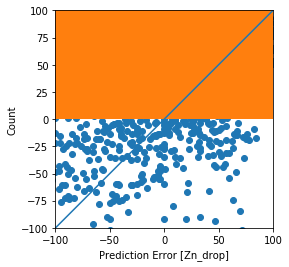

In [45]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Zn_drop]')
plt.ylabel('Predictions [Zn_drop]')

lims = [-100, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Zn_drop]")
_ = plt.ylabel("Count")

In [84]:
#model_Zdrop.save(r'C:\Users\v.t.flores\Documents\Zn_drop_TF_model9')
model.save(r'C:\Users\v.t.flores\Documents\Zn_drop_TF_model10')

# Zn_drop_TF_model8 ---> increased the neurons to 512 from 64, increased the layers to 5, added L2 regularization
# and dropout

#new_model = tf.keras.models.load_model(r'C:\Users\v.t.flores\Documents\Zn_drop_TF_model')
#print(new_model.predict(test_images).shape)

In [30]:
len(normed_test_data.columns)

34

In [31]:
normed_test_data.columns

Index(['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu', '104_Fe', '104_Fe2',
       '104_Ft', '104_Mg', '104_Mn', '104_NTU', '104_Ni', '104_ORP', '104_Pb',
       '104_Si', '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'DeZn_TK05_T', 'H2S_tk01', 'H2S_tk02', 'tk05_Al', 'tk05_Ca', 'tk05_Co',
       'tk05_Cr', 'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn', 'tk05_Ni',
       'tk05_Pb', 'tk05_Si', 'tk05_Zn'],
      dtype='object')